In [1]:
# Comment Line 
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy

# First we need to define the lattice length
# next multiply by the a constant to convert to angstrom
# Nums is the number of atoms
alat = 29.00
alat_ang = alat*0.529
nums = list(range(257))

atom_num = 256
dist = []
r = 0
cluster = []
averages = []
columb_force = []

# Coulumb Constant : Units : N m^2 C^-2
colum = 9.0*10**29
e2 = (1.602*10**-19)**2


n = 0

# lattice lengths a for x, b for y, c for z
a = 15.341
b = 15.341
c = 15.341

cutoff = 3.5

newfilename = 'sep23_1_atom_displacement'

######
# READ IN FILE , USE SPLIT TO SEPERATE OUT ALL VALUES
######

# Open file, proceed to write out a new file where atom names are replaced so that Lammps can read it

with open("sep23.1_final_structure", "rt") as fin:
    with open("atom_pos_temp", "wt") as fout: 
        for line in fin: 
            fout.write((line.replace('Pt', '1')).replace('Ni','2').replace('P','3'))
    
with open('atom_pos_temp') as f:
    alines = f.read().split()

######
# Use float to convert to float numbers
######
xpos = []
ypos = []
zpos = []
atom = []

axpos = []
aypos = []
azpos = []
aatom = []


n = 1
while n < 1024:
    aatom.append(alines[n-1])
    axpos.append(float(alines[n]))
    aypos.append(float(alines[n+1]))
    azpos.append(float(alines[n+2]))
    n += 4

######
# Now multiply out atom positions into Angstroms
######

n = 0 
while n < 256:
    axpos[n] = axpos[n]*alat_ang
    aypos[n] = aypos[n]*alat_ang
    azpos[n] = azpos[n]*alat_ang
    n += 1


######
# Now make a list of charges for each atom
######
charge = []
n = 0
while n < 256:
    if float(aatom[n]) == 1:
        charge.append(78)
    if float(aatom[n]) == 2:
        charge.append(28)
    if float(aatom[n]) == 3:
        charge.append(15)
    n += 1


# Now calculate distance doing loop
# since cell is 3-D there are 9 periodic cells around the box which means that per atom there are 10 distance calculations done
# num will be number of atoms * 10
# Need two loops 1 loop is for each atom, the second loop 


# Empty lists that will be used
# to compute x, y and z components 
xtemp  = []
ytemp  = []
ztemp  = []


xfield = []
yfield = []
zfield = []

#####
# Beginning of Indicie List
#####

# We can calculate new x2, y2 and z2 values 
# Now make a list of all possible combinations
i = []
j = []
k = []

indicies = [0,0,0,1,0,0,0,1,0,0,0,1,1,1,0,1,0,1,0,1,1,1,1,1]
#all negative indicies
indicies.extend([-1,0,0,0,-1,0,0,0,-1,-1,-1,0,-1,0,-1,0,-1,-1,-1,-1,-1])
# now we need mixed indicies 
indicies.extend([-1,-1,1,-1,1,-1,1,-1,-1])
indicies.extend([-1,1,1,1,-1,1,1,1,-1])
indicies.extend([0,-1,1,0,1,-1,-1,0,1,-1,1,0])
   
n = 0  
while n < 75:
    # print(str(indicies[n])+' '+str(indicies[n+1])+' '+str(indicies[n+2]))
    i.append(indicies[n])
    j.append(indicies[n+1])
    k.append(indicies[n+2])
    n += 3
    
#####
# END OF INDICIE LIST
#####

# Now do distance calculation changing x2, y2 and z2 based on i, j and k indicies 
# We need multiple loops to execute the distance calculation
# outermost loop is to range over atoms r 
# next loop over atoms m
# final loop is to calculate atom m + images

# Initially we had set up to avoid double counting, however double counting is actually necesasry 


while r <= (atom_num-1):
    m = 0
    while (m) <= (atom_num-1):
        n = 0
        while n < (25):
                x1 = axpos[r]
                y1 = aypos[r]
                z1 = azpos[r]
                x2 = axpos[m]+i[n]*a
                y2 = aypos[m]+j[n]*b
                z2 = azpos[m]+k[n]*c
                dist_image = np.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)
                if dist_image < cutoff and r != m:
                    # now use if statements to choose which atom types and get charge information
                    # We will compute comlumbic force contributions for each x, y and z component
                    force = (colum*e2*charge[r]*charge[m])/(dist_image)**2
                    xtemp.append(force*(x1-x2))
                    ytemp.append(force*(y1-y2))
                    ztemp.append(force*(z1-z2))
                    #print('Distance is less then cutoff')
                    #print(dist_image)
                    #print off indicies for the PBE cells and Atom Index
                    #print('Atom Index A:',r,'Atom Index B:',(m))
                    #print(str(i[n])+ ' '+str(j[n])+ ' '+ str(k[n])) 
                    #print('\n')                
                n += 1
        m += 1
    if len(xtemp) != 0:
        columb_force.append(force)
        xfield.append(np.sum(xtemp))
        yfield.append(np.sum(ytemp))
        zfield.append(np.sum(ztemp))
        xtemp = []
        ytemp = []
        ztemp = []
    r += 1

######
# End of the Calculation
######

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy

######
# Prepare Lammps file with Vectors
######

######
# Prepare Lammps File
######

# We are going to print out the final structure with an additional column for distance moved
text = []

n = 0
while n < 256:
    text.append((str(nums[1+n])+' '+str(aatom[n])+' '+str(axpos[n])+ ' '+str(aypos[n])+' '+str(azpos[n])+' '+str(xfield[n])+' '+str(yfield[n])+' '+str(zfield[n])+' '+str(columb_force[n])))
    n += 1  

#####
# Top formatting
#####  
newfilename = 'sep23_1_columb_force'

file = open(newfilename, "w")
# First 3 write lines are to show size of simulation box
file.write('ITEM: TIMESTEP')
file.write('\n'+'0')
file.write('\n'+'ITEM: NUMBER OF ATOMS')
file.write('\n'+'256')
file.write('\n'+'ITEM: BOX BOUNDS pp pp pp')
file.write('\n'+'0'+' '+ str(alat_ang))
file.write('\n'+'0'+' '+str(alat_ang))
file.write('\n'+'0'+' '+str(alat_ang))
file.write('\n'+'ITEM: ATOMS id type x y z fx fy fz force \n')

#####
# Write out text to the end of file
#####

with open(newfilename, 'w') as f:
    for row in text:
        file.write("%s\n" % str(row))
        
file.close()

In [ ]:
# Comment Line 

import math
import numpy as np
import matplotlib.pyplot as plt
import scipy

# First we need to define the lattice length
# next multiply by the a constant to convert to angstrom
# Nums is the number of atoms
alat = 29.00
alat_ang = alat*0.529
nums = list(range(4))

atom_num = 3
dist = []

# Coulumb Constant : Units : N m^2 C^-2
colum = 9.0*10**29
e2 = (1.602*10**-19)**2


# lattice lengths a for x, b for y, c for z
a = 15.341
b = 15.341
c = 15.341

cutoff = 3.5

######
# Use float to convert to float numbers
######

xpos = []
ypos = []
zpos = []
atom = []

axpos = []
aypos = []
azpos = []
aatom = []


n = 1
while n < 12:
    aatom.append(alines[n-1])
    axpos.append(float(alines[n]))
    aypos.append(float(alines[n+1]))
    azpos.append(float(alines[n+2]))
    n += 4


######
# Now make a list of charges for each atom
######
charge = []
n = 0
while n < 3:
    if float(aatom[n]) == 1:
        charge.append(78)
    if float(aatom[n]) == 2:
        charge.append(28)
    if float(aatom[n]) == 3:
        charge.append(15)
    n += 1


# Now calculate distance doing loop
# since cell is 3-D there are 9 periodic cells around the box which means that per atom there are 10 distance calculations done
# num will be number of atoms * 10
# Need two loops 1 loop is for each atom, the second loop 


# Empty lists that will be used
# to compute x, y and z components 
xtemp  = []
ytemp  = []
ztemp  = []


xfield = []
yfield = []
zfield = []

#####
# Beginning of Indicie List
#####

# We can calculate new x2, y2 and z2 values 
# Now make a list of all possible combinations
i = []
j = []
k = []

indicies = [0,0,0,1,0,0,0,1,0,0,0,1,1,1,0,1,0,1,0,1,1,1,1,1]
#all negative indicies
indicies.extend([-1,0,0,0,-1,0,0,0,-1,-1,-1,0,-1,0,-1,0,-1,-1,-1,-1,-1])
# now we need mixed indicies 
indicies.extend([-1,-1,1,-1,1,-1,1,-1,-1])
indicies.extend([-1,1,1,1,-1,1,1,1,-1])
indicies.extend([0,-1,1,0,1,-1,-1,0,1,-1,1,0])
   
n = 0  
while n < 75:
    # print(str(indicies[n])+' '+str(indicies[n+1])+' '+str(indicies[n+2]))
    i.append(indicies[n])
    j.append(indicies[n+1])
    k.append(indicies[n+2])
    n += 3
    
#####
# END OF INDICIE LIST
#####

# Now do distance calculation changing x2, y2 and z2 based on i, j and k indicies 
# We need multiple loops to execute the distance calculation
# outermost loop is to range over atoms r 
# next loop over atoms m
# final loop is to calculate atom m + images
m = 0
r = 0
x = 0
cluster = []
averages = []
# Initially we had set up to avoid double counting, however double counting is actually necesasry 


while r <= (atom_num-1):
    m = 0
    while (m) <= (atom_num-1):
        n = 0
        while n < (25):
                x1 = axpos[r]
                y1 = aypos[r]
                z1 = azpos[r]
                x2 = axpos[m]+i[n]*a
                y2 = aypos[m]+j[n]*b
                z2 = azpos[m]+k[n]*c
                dist_image = np.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)
                if dist_image < cutoff and r != m:
                    # now use if statements to choose which atom types and get charge information
                    # We will compute comlumbic force contributions for each x, y and z component
                    xtemp.append((colum*e2*charge[r]*charge[m])/(axpos[r]-axpos[m])**2)
                    ytemp.append((colum*e2*charge[r]*charge[m])/(aypos[r]-aypos[m])**2)
                    ztemp.append((colum*e2*charge[r]*charge[m])/(azpos[r]-azpos[m])**2)
                    #print('Distance is less then cutoff')
                    #print(dist_image)
                    #print off indicies for the PBE cells and Atom Index
                    #print('Atom Index A:',r,'Atom Index B:',(m))
                    #print(str(i[n])+ ' '+str(j[n])+ ' '+ str(k[n])) 
                    #print('\n')                
                n += 1
        m += 1
    if len(xtemp) != 0:
        xfield.append(np.sum(xtemp))
        yfield.append(np.sum(ytemp))
        zfield.append(np.sum(ztemp))
        xtemp = []
        ytemp = []
        ztemp = []
    r += 1

######
# End of the Calculation
######

In [5]:
######
# Electric Field Calculation
# Input QE structure and calculate electric field
# over a series of points on a 3-D grid
######
import math
import numpy as np
import matplotlib.pyplot as plt
import time
######
# Inputs that maybe changed for simulation
######
# First we need to define the lattice length
# next multiply by the a constant to convert to angstrom
# atom_num is number of atoms in simulation
filename = 'sep23.1_final_structure_efield'
alat = 29.00
alat_ang = alat*0.529
atom_num = 256

# Inner and outer cutoff define the range of the Columb potential
# We have an inner cutoff to ignore self field
cutoff_out = 3.0
cutoff_in  = 1.0

# lattice lengths a for x, b for y, c for z
a = 15.341
b = 15.341
c = 15.341
######
# Define constants for simulation
######

# Coulumb Constant : Units : N m^2 C^-2
colum = 9.0*10**29
e2 = (1.602*10**-19)**2

print("Number of Atoms for Calcululation:",atom_num)
print("Done With Variables")
######
# Create all empty lists
######
xpos,ypos,zpos,atom,axpos,aypos,azpos,aatom,charge = ([] for i in range(9))
xtemp,ytemp,ztemp,xfield,yfield,zfield,etemp,efield,i,j,k,text = ([] for i in range(12))

######
# Input the structure
######
with open("sep23.1_final_structure", "rt") as fin:
    with open("atom_pos_temp", "wt") as fout: 
        for line in fin: 
            fout.write((line.replace('Pt', '1')).replace('Ni','2').replace('P','3'))
    
with open('atom_pos_temp') as f:
    lines = f.read().split()

n = 1
while n < (atom_num*4):
    atom.append(lines[n-1])
    xpos.append(float(lines[n]))
    ypos.append(float(lines[n+1]))
    zpos.append(float(lines[n+2]))
    n += 4

######
# Now make a list of charges for each atom
######
n = 0
while n < atom_num:
    if float(atom[n]) == 1:
        charge.append(78)
    if float(atom[n]) == 2:
        charge.append(28)
    if float(atom[n]) == 3:
        charge.append(15)
    n += 1
print("Done  With Charges and Lists")
#####
# Beginning of Indicie List
#####

# We can calculate new x2, y2 and z2 values 
# Now make a list of all possible combinations

indicies = [0,0,0,1,0,0,0,1,0,0,0,1,1,1,0,1,0,1,0,1,1,1,1,1]
#all negative indicies
indicies.extend([-1,0,0,0,-1,0,0,0,-1,-1,-1,0,-1,0,-1,0,-1,-1,-1,-1,-1])
# now we need mixed indicies 
indicies.extend([-1,-1,1,-1,1,-1,1,-1,-1])
indicies.extend([-1,1,1,1,-1,1,1,1,-1])
indicies.extend([0,-1,1,0,1,-1,-1,0,1,-1,1,0])
   
n = 0  
while n < 75:
    # print(str(indicies[n])+' '+str(indicies[n+1])+' '+str(indicies[n+2]))
    i.append(indicies[n])
    j.append(indicies[n+1])
    k.append(indicies[n+2])
    n += 3
    
#####
# END OF INDICIE LIST
#####

# Now do distance calculation changing x2, y2 and z2 based on i, j and k indicies 
# We need multiple loops to execute the distance calculation
# outermost loop is to range over atoms r 
# next loop over atoms m
# final loop is to calculate atom m + images
 
x = np.arange(0,15.341,.192)
y = np.arange(0,15.341,.192)
z = np.arange(0,15.341,.192)
check_list = []

print("Done with Indicies and Arrangement")

l = 0
# x-loop
while l < len(x):
    # x-loop
    m = 0
    while m < len(y):
        # y-loop
        n = 0
        while n < len(z):
            # z-loop
            o = 0
            while o <= (atom_num-1):
                # atom-loop
                p = 0
                while p < 25:
                    #periodic images loop
                    x1 = xpos[o]
                    y1 = ypos[o]
                    z1 = zpos[o]
                    x2 = x[l]
                    y2 = y[m]
                    z2 = z[n]
                    dist_image = np.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)
                    if dist_image < cutoff_out and dist_image > cutoff_in:
                        etemp.append((colum*e2*charge[o])/((zpos[o]-z[n])**2))
                        check_list.append(1)
                    p += 1
                o += 1
            # Before we move to new coordinate 
            # sum up etemp values to efield
            if len(etemp) != 0:
                efield.append(np.sum(etemp))
                etemp = []
            else:
                efield.append(0)
            n += 1
        m += 1
    print((1.25*l+1.25),"% Complete!:")
    l += 1
    
######
# End of the Calculation
######

######
# Write out lines to file from efield
######

n = 0
while n < len(efield):
    text.append(str(efield[n]))
    n += 1 

#filename defined at top

with open(filename, 'w') as f:
    for row in text:
        f.write("%s\n" % str(row))
        
f.close()

Number of Atoms for Calcululation: 256
Done With Variables
Done  With Charges and Lists
Done with Indicies and Arrangement
1.25 % Complete!:
2.5 % Complete!:
3.75 % Complete!:
5.0 % Complete!:
6.25 % Complete!:
7.5 % Complete!:
8.75 % Complete!:
10.0 % Complete!:
11.25 % Complete!:
12.5 % Complete!:
13.75 % Complete!:
15.0 % Complete!:
16.25 % Complete!:
17.5 % Complete!:
18.75 % Complete!:
20.0 % Complete!:
21.25 % Complete!:
22.5 % Complete!:
23.75 % Complete!:
25.0 % Complete!:
26.25 % Complete!:
27.5 % Complete!:
28.75 % Complete!:
30.0 % Complete!:
31.25 % Complete!:
32.5 % Complete!:
33.75 % Complete!:
35.0 % Complete!:
36.25 % Complete!:
37.5 % Complete!:
38.75 % Complete!:
40.0 % Complete!:
41.25 % Complete!:
42.5 % Complete!:
43.75 % Complete!:
45.0 % Complete!:
46.25 % Complete!:
47.5 % Complete!:
48.75 % Complete!:
50.0 % Complete!:
51.25 % Complete!:
52.5 % Complete!:
53.75 % Complete!:
55.0 % Complete!:
56.25 % Complete!:
57.5 % Complete!:
58.75 % Complete!:
60.0 % Complet

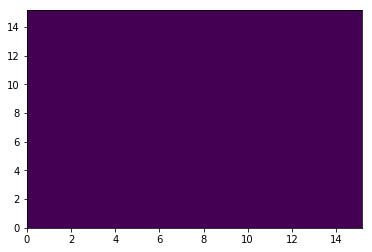

In [44]:
file_load = "sep23.1_final_structure_efield"

with open(file_load) as f:
    content = f.read().splitlines()

content = [float(i) for i in content]
n = 75*6400
m = n+6400
efield = np.array([content[n:m]]).reshape(80,80)
x = np.arange(0,15.341,.192)
y = np.arange(0,15.341,.192)
X, Y = np.meshgrid(x,y)




plt.pcolor(X,Y,efield)
plt.show()